In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Resizing,Rescaling,InputLayer,BatchNormalization,Flatten,Conv2D,MaxPool2D,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.regularizers import L2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES =["angry","happy","sad"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE" : 256,
    "DROPOUT_RATE" : 0.0 ,
    "REGULARIZATION_RATE" : 0.0,
    "N_FILTERS" : 6,
    "N_STRIDES" : 1,
    "KERNEL_SIZE" :3,
    "POOL_SIZE" : 2,
    "N_EPOCHS" : 20,
    "N_DENSE_1" : 100,
    "N_DENSE_2" : 10,
    "NUM_CLASSES" : 3,
    "LEARNING_RATE" :0.001,

}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 305M/309M [00:03<00:00, 27.9MB/s]
100% 309M/309M [00:03<00:00, 81.9MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,

)

Found 2278 files belonging to 3 classes.


In [ ]:
for i in train_dataset.take(1) :
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

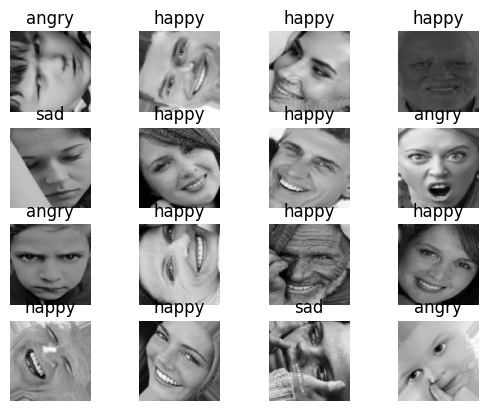

In [ ]:
for images,labels in train_dataset.take(1):
  for i in range(16) :
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0).numpy()])
    plt.axis("off")


In [ ]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    Rescaling(1./255),
])

In [ ]:
model = tf.keras.Sequential([
                              InputLayer(input_shape=(None,None,3)),
                              resize_rescale_layers,

                              Conv2D(filters=CONFIGURATION['N_FILTERS'],kernel_size=CONFIGURATION['KERNEL_SIZE'],strides=CONFIGURATION['N_STRIDES'],
                                     padding='valid',activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),
                              Dropout(rate = CONFIGURATION['DROPOUT_RATE']),

                              Conv2D(filters=CONFIGURATION['N_FILTERS']*2+4,kernel_size=CONFIGURATION['KERNEL_SIZE'],strides=CONFIGURATION['N_STRIDES'],
                                     padding='valid',activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              MaxPool2D(pool_size=CONFIGURATION['POOL_SIZE'],strides=CONFIGURATION['N_STRIDES']*2),

                              Flatten(),
                              Dense(CONFIGURATION['N_DENSE_1'],activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              Dropout(rate = CONFIGURATION['DROPOUT_RATE']),
                              Dense(CONFIGURATION['N_DENSE_2'],activation='relu',kernel_regularizer = L2(CONFIGURATION['REGULARIZATION_RATE'])),
                              BatchNormalization(),
                              Dense(CONFIGURATION['NUM_CLASSES'],activation='softmax'),

])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_8 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
loss_function= CategoricalCrossentropy()

In [ ]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2,name = "top_k_accuracy")]

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics ,
    )

In [ ]:
history = model.fit(
    training_dataset,
    validation_data= validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 17s 64ms/step - loss: 1.0297 - accuracy: 0.5686 - top_k_accuracy: 0.8222 - val_loss: 1.0306 - val_accuracy: 0.5075 - val_top_k_accuracy: 0.7770
Epoch 2/20
213/213 [==============================] - 14s 64ms/step - loss: 0.7212 - accuracy: 0.6900 - top_k_accuracy: 0.8959 - val_loss: 1.0521 - val_accuracy: 0.5040 - val_top_k_accuracy: 0.8082
Epoch 3/20
213/213 [==============================] - 15s 70ms/step - loss: 0.4973 - accuracy: 0.7989 - top_k_accuracy: 0.9481 - val_loss: 0.8934 - val_accuracy: 0.6089 - val_top_k_accuracy: 0.8815
Epoch 4/20
213/213 [==============================] - 14s 65ms/step - loss: 0.3243 - accuracy: 0.8869 - top_k_accuracy: 0.9760 - val_loss: 0.8974 - val_accuracy: 0.6760 - val_top_k_accuracy: 0.8881
Epoch 5/20
213/213 [==============================] - 14s 67ms/step - loss: 0.2244 - accuracy: 0.9263 - top_k_accuracy: 0.9851 - val_loss: 1.1072 - val_accuracy: 0.5724 - val_top_k_accuracy: 0.8130
Epoch 6/20

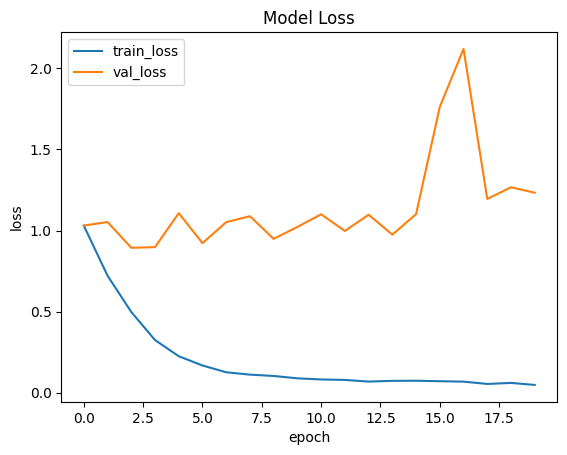

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'])
plt.show()

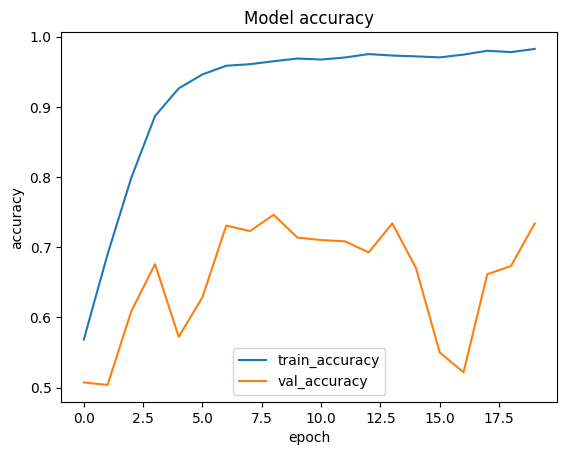

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

In [ ]:
model.evaluate(validation_dataset)

72/72 [==============================] - 3s 36ms/step - loss: 1.2331 - accuracy: 0.7340 - top_k_accuracy: 0.8955


[1.2331187725067139, 0.733977198600769, 0.89552241563797]

In [ ]:
predicted = []
labels = []
for im,label in validation_dataset :
  predicted.append(model(im))
  labels.append(label.numpy())

In [ ]:
pred = np.argmax(predicted[:-1],axis=-1).flatten()
lab = np.argmax(labels[:-1],axis=-1).flatten()

[[303 119  91]
 [ 52 842 110]
 [ 77 155 523]]


Text(0.5, 58.7222222222222, 'predicted')

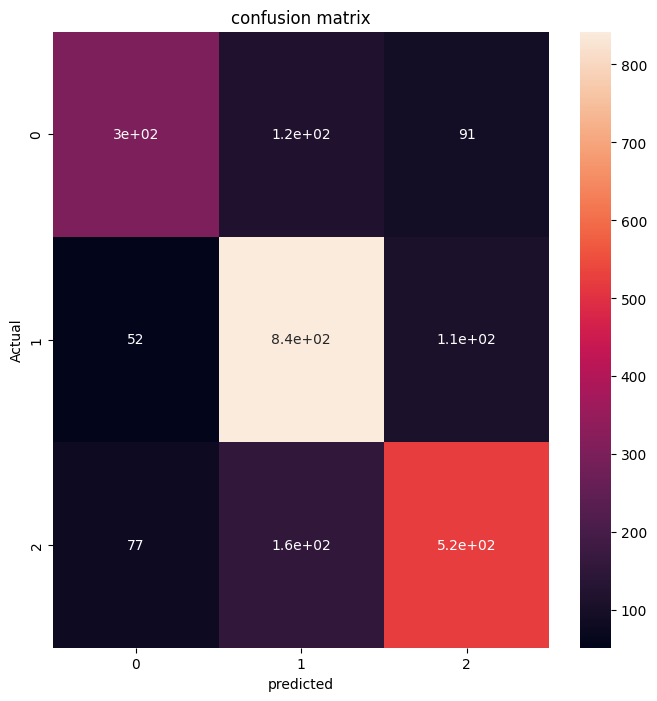

In [ ]:
cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True)
plt.title("confusion matrix")
plt.ylabel('Actual')
plt.xlabel('predicted')